# APS SENSOR FAULT DETECTION & PREDICTION

## 1.Problem Statement
<span style="color:blue">**Description:**</span> The Scania Air Pressure System(APS) is an integral component in heavy trucks, responsible for generating pressurized air used in vital functions such as braking and gear changing.
   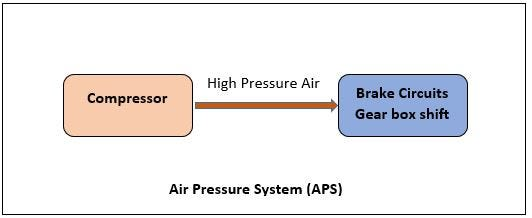
   
<span style="color:blue">**Goal:**</span> We want to reduce the cost of maintanance checks and unnecessary repairs. So it is crucial to minimize the false predictions. Lets deep dive into the cost function, by the help of confusion matrix:
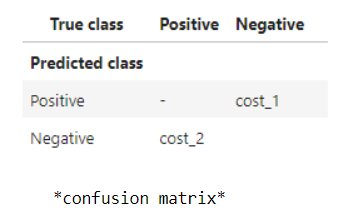

- here "False Positive" refers to cases where we wrongly predict sensor data as indicating a fault, while there is no actual fault present.
- here "False Negative" means that we predicted the sensor data as normal/not fault but in reality there is a signal saying the related component of the truck requires maintenance.
- furthermore, as SCANIA says; cost2: cost produced due to false negative is 50 times higher than the cos1, so we need to focus more on reducing false negative predictions.

# 2. Import Required Libraries

In [8]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 

import warnings 

from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer, OneHotEncoder,MinMaxScaler, StandardScaler,RobustScaler 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, \
                            precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from autofeat import AutoFeatClassifier

from ydata_profiling import ProfileReport
import dtale

warnings.filterwarnings("ignore")
%matplotlib inline 
pd.set_option('display.float_format', lambda x: '%.1f' % x)

C:\Users\ayhan\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\ayhan\anaconda3\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit
2023-08-06 18:02:08,653 INFO: Pandas backend loaded 1.5.3
2023-08-06 18:02:08,661 INFO: Numpy backend loaded 1.23.5
2023-08-06 18:02:08,663 INFO: Pyspark backend NOT loaded
20

***

# 3. Data Ingestion and descriptive analysis of the dataset

In [14]:
df= pd.read_csv("dataset/aps-data/aps_failure_training_set.csv",header=0)

In [15]:
df.shape 

(60000, 171)

In [16]:
df["class"].unique()

array(['neg', 'pos'], dtype=object)

In [17]:
TARGET_COLUMN = "class"

In [18]:
df[TARGET_COLUMN] = df[TARGET_COLUMN].replace({"neg":0,"pos":1}) 

In [19]:
df["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

#### !!! So, we are dealing with an imbalanced data, we need to take this into account

### 3.a ANALYZE THE FEATURES

In [20]:
def grab_columns(dataframe:pd.DataFrame, cat_th=10, car_th =20):
    
    #categoric columns
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes!="O" and dataframe[col].nunique()<cat_th]
    cat_but_car = [col for col in cat_cols if dataframe[col].nunique()>car_th]
    cat_cols = num_but_cat + cat_cols
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #numeric columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int","float"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations:{dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat but high cardinal: {len(cat_but_car)}")
    print(f"num but cat:{len(num_but_cat)}")
    
    return cat_cols, num_cols, cat_but_car



In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(2), object(169)
memory usage: 78.3+ MB


In [22]:
cat_cols, num_cols, cat_but_car = grab_columns(df.drop(columns=["class"],axis=1))

Observations:60000
Variables: 170
cat_cols: 2
num_cols: 0
cat but high cardinal: 167
num but cat:0


In [23]:
df[cat_but_car]

,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,na,2130706438,280,0,0,0,0,0,0,37250,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,na,0,na,0,0,0,0,0,0,18254,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,na,228,100,0,0,0,0,0,0,1648,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,70,66,0,10,0,0,0,318,2212,...,240,46,58,44,10,0,0,0,4,32
4,na,1368,458,0,0,0,0,0,0,43752,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,na,664,186,0,0,0,0,0,2564,59100,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,na,2130706538,224,0,0,0,0,0,0,104,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,0,2130706432,18,0,0,0,0,0,0,28,...,792,386,452,144,146,2622,0,0,0,0
59998,na,2130706432,494,0,0,0,0,0,0,330,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


### 3.b Check missing values and handle dtype conversions

In [24]:
df[cat_but_car] = df[cat_but_car].apply(lambda x: pd.to_numeric(x.replace("na",np.nan)))


In [14]:
"""%%timeit -r 7 -n 10
# turn object dtypes into numeric dtype and replace string na with np.nan float
df[cat_but_car] = pd.concat([pd.to_numeric(df[col].replace("na",np.nan)) for col in cat_but_car],axis=1)"""

'%%timeit -r 7 -n 10\n# turn object dtypes into numeric dtype and replace string na with np.nan float\ndf[cat_but_car] = pd.concat([pd.to_numeric(df[col].replace("na",np.nan)) for col in cat_but_car],axis=1)'

In [25]:
#update num_cols
num_cols = cat_but_car

In [26]:
num_cols.insert(0,"aa_000")

In [27]:
cat_cols

['cd_000', 'ch_000']

In [28]:
# replace string na with np.nan float for categorical features
df[cat_cols] = df[cat_cols].replace("na",np.nan)

In [29]:
df[num_cols].isna().sum().sort_values(ascending=False)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
cr_000    46329
          ...  
ck_000      338
cj_000      338
ci_000      338
bt_000      167
aa_000        0
Length: 168, dtype: int64

In [30]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
aa_000,60000.0,59336.5,145430.1,0.0,834.0,30776.0,48668.0,2746564.0
ab_000,13671.0,0.7,3.5,0.0,0.0,0.0,0.0,204.0
ac_000,56665.0,356014263.0,794874918.5,0.0,16.0,152.0,964.0,2130706796.0
ad_000,45139.0,190620.6,40404411.4,0.0,24.0,126.0,430.0,8584297742.0
ae_000,57500.0,6.8,161.5,0.0,0.0,0.0,0.0,21050.0
...,...,...,...,...,...,...,...,...
ee_007,59329.0,346271.4,1728056.0,0.0,110.0,41098.0,167814.0,119580108.0
ee_008,59329.0,138730.0,449510.0,0.0,0.0,3812.0,139724.0,19267396.0
ee_009,59329.0,8388.9,47470.4,0.0,0.0,0.0,2028.0,3810078.0
ef_000,57276.0,0.1,4.4,0.0,0.0,0.0,0.0,482.0


In [31]:
df[num_cols].max().sort_values()

ab_000          204.0
ar_000          350.0
ef_000          482.0
eg_000         1146.0
dz_000         1414.0
             ...     
ac_000   2130706796.0
dq_000   6351872864.0
cf_000   8584297736.0
ad_000   8584297742.0
co_000   8584297742.0
Length: 168, dtype: float64

#### !!! as we observe, then scale of the features range a lot, so a some type of Scaling is a must

In [32]:
df[cat_cols].isna().sum()

cd_000      676
ch_000    14861
dtype: int64

In [33]:
def missing_values_table(dataframe:pd.DataFrame,na_name=False, ratio_th=5,print_table=False,drop_th=70):
    na_cols = [col for col in dataframe.columns if  dataframe[col].isna().any().sum()>0 ]
    na_data = dataframe[na_cols].isna().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.concat(objs=[na_data,np.round(ratio,2)],axis=1,keys=["# missing", "% missing"])
    if print_table:
        print(missing_df[missing_df["% missing"]>ratio_th],end='\n')
    if na_name:
        return [col for col in na_cols if ratio[col]>=drop_th]
    

In [34]:
missing_values_table(df[num_cols],True,20,True)

        # missing  % missing
br_000      49264       82.1
bq_000      48722       81.2
bp_000      47740       79.6
bo_000      46333       77.2
ab_000      46329       77.2
cr_000      46329       77.2
bn_000      44009       73.3
bm_000      39549       65.9
bl_000      27277       45.5
bk_000      23034       38.4
cg_000      14861       24.8
co_000      14861       24.8
cf_000      14861       24.8
ad_000      14861       24.8
db_000      13808       23.0
ct_000      13808       23.0
cu_000      13808       23.0
cv_000      13808       23.0
cx_000      13808       23.0
cy_000      13808       23.0
cz_000      13808       23.0
da_000      13808       23.0
dc_000      13808       23.0


['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']

In [35]:
missing_values_table(dataframe=df[num_cols],na_name=False,ratio_th=5,print_table=True)

        # missing  % missing
br_000      49264       82.1
bq_000      48722       81.2
bp_000      47740       79.6
bo_000      46333       77.2
ab_000      46329       77.2
cr_000      46329       77.2
bn_000      44009       73.3
bm_000      39549       65.9
bl_000      27277       45.5
bk_000      23034       38.4
cg_000      14861       24.8
co_000      14861       24.8
cf_000      14861       24.8
ad_000      14861       24.8
db_000      13808       23.0
ct_000      13808       23.0
cu_000      13808       23.0
cv_000      13808       23.0
cx_000      13808       23.0
cy_000      13808       23.0
cz_000      13808       23.0
da_000      13808       23.0
dc_000      13808       23.0
ec_00       10239       17.1
cm_000       9877       16.5
cl_000       9553       15.9
ed_000       9553       15.9
ak_000       4400        7.3
ca_000       4356        7.3
dm_000       4009        6.7
dh_000       4008        6.7
dg_000       4008        6.7
df_000       4008        6.7
dl_000       4

In [36]:
[col for col in num_cols if df[col].isna().sum()==0]

['aa_000']

### so we observe that there are some numeric columns having more than 80% missing values, furthermore, there is only 1 numeric input feature not having any missing value, so a missing value handling operation is mandatory for this data set.

In [37]:
missing_values_table(dataframe=df[cat_cols],na_name=True,ratio_th=0,print_table=True)

        # missing  % missing
ch_000      14861       24.8
cd_000        676        1.1


[]

### and there are 2 categorical (of numeric dtype) input features, one of them having almost 25% and the other one having 1% missing values. So we will also handle these missing values.

### 3.c Analyze missing values with respect to target variable

In [38]:
df[TARGET_COLUMN]

0        0
1        0
2        0
3        0
4        0
        ..
59995    0
59996    0
59997    0
59998    0
59999    0
Name: class, Length: 60000, dtype: int64

In [39]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [40]:
def missing_vs_target(dataframe, target, na_cols):
    temp_df = dataframe.copy()
    for col in na_cols:
        temp_df[col+ "_NA_FLAG"] = np.where(temp_df[col].isna(),1,0)
    na_flags= [col for col in temp_df.columns if "_NA_FLAG" in col]
    
    for col in na_flags:
        ratio = temp_df.groupby(col)[target].count()/temp_df[col].shape[0]
        print(pd.DataFrame({
            "Target_mean": temp_df.groupby(col)[target].mean(),
            "count" : temp_df.groupby(col)[target].count(),
            "ratio" : ratio
        }),end="\n\n\n")
        if 1 in ratio.index:
            if ratio[1]>0.04:
                print(col)

In [41]:
missing_vs_target(dataframe=df,target=TARGET_COLUMN,na_cols=cat_cols)

                Target_mean  count  ratio
cd_000_NA_FLAG                           
0                     0.016  59324  0.989
1                     0.064    676  0.011


                Target_mean  count  ratio
ch_000_NA_FLAG                           
0                     0.008  45139  0.752
1                     0.043  14861  0.248


ch_000_NA_FLAG


### where cd_000 is nan: 0.64% of the times class is positive , where ch_000 is nan: 4% of the times class is positive>>> so there is no real meaning / correlation btw missing and target values

In [42]:
missing_vs_target(dataframe=df,target=TARGET_COLUMN,na_cols=num_cols)

                Target_mean  count  ratio
aa_000_NA_FLAG                           
0                     0.017  60000  1.000


                Target_mean  count  ratio
ab_000_NA_FLAG                           
0                     0.017  13671  0.228
1                     0.017  46329  0.772


ab_000_NA_FLAG
                Target_mean  count  ratio
ac_000_NA_FLAG                           
0                     0.009  56665  0.944
1                     0.139   3335  0.056


ac_000_NA_FLAG
                Target_mean  count  ratio
ad_000_NA_FLAG                           
0                     0.008  45139  0.752
1                     0.043  14861  0.248


ad_000_NA_FLAG
                Target_mean  count  ratio
ae_000_NA_FLAG                           
0                     0.011  57500  0.958
1                     0.136   2500  0.042


ae_000_NA_FLAG
                Target_mean  count  ratio
af_000_NA_FLAG                           
0                     0.011  57500  0.958
1     

                Target_mean  count  ratio
az_006_NA_FLAG                           
0                     0.017  59329  0.989
1                     0.007    671  0.011


                Target_mean  count  ratio
az_007_NA_FLAG                           
0                     0.017  59329  0.989
1                     0.007    671  0.011


                Target_mean  count  ratio
az_008_NA_FLAG                           
0                     0.017  59329  0.989
1                     0.007    671  0.011


                Target_mean  count  ratio
az_009_NA_FLAG                           
0                     0.017  59329  0.989
1                     0.007    671  0.011


                Target_mean  count  ratio
ba_000_NA_FLAG                           
0                     0.017  59312  0.989
1                     0.006    688  0.011


                Target_mean  count  ratio
ba_001_NA_FLAG                           
0                     0.017  59312  0.989
1                     0.

                Target_mean  count  ratio
cn_001_NA_FLAG                           
0                     0.017  59313  0.989
1                     0.006    687  0.011


                Target_mean  count  ratio
cn_002_NA_FLAG                           
0                     0.017  59313  0.989
1                     0.006    687  0.011


                Target_mean  count  ratio
cn_003_NA_FLAG                           
0                     0.017  59313  0.989
1                     0.006    687  0.011


                Target_mean  count  ratio
cn_004_NA_FLAG                           
0                     0.017  59313  0.989
1                     0.006    687  0.011


                Target_mean  count  ratio
cn_005_NA_FLAG                           
0                     0.017  59313  0.989
1                     0.006    687  0.011


                Target_mean  count  ratio
cn_006_NA_FLAG                           
0                     0.017  59313  0.989
1                     0.

                Target_mean  count  ratio
dx_000_NA_FLAG                           
0                     0.011  57277  0.955
1                     0.138   2723  0.045


dx_000_NA_FLAG
                Target_mean  count  ratio
dy_000_NA_FLAG                           
0                     0.011  57276  0.955
1                     0.138   2724  0.045


dy_000_NA_FLAG
                Target_mean  count  ratio
dz_000_NA_FLAG                           
0                     0.011  57277  0.955
1                     0.138   2723  0.045


dz_000_NA_FLAG
                Target_mean  count  ratio
ea_000_NA_FLAG                           
0                     0.011  57277  0.955
1                     0.138   2723  0.045


ea_000_NA_FLAG
                Target_mean  count  ratio
eb_000_NA_FLAG                           
0                     0.009  55993  0.933
1                     0.131   4007  0.067


eb_000_NA_FLAG
               Target_mean  count  ratio
ec_00_NA_FLAG                     

### we observe that times the num col values are missing, the target columns is positive by a range between 0.02% and 14%, so there is no strong correlation here also. we can neglect this effect.

In [43]:
df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100

8.284746588693958

### overall, 8.2% of the data is missing.

# AUTOFEAT lib kullan

*******

### 3.d LET'S EXPLORE THE FEATURES by the help of some useful libraries

#### 1. PANDAS PROFILING

In [1]:
""" profile = ProfileReport(df,minimal=True,explorative=True,dark_mode=True)
profile.to_notebook_iframe()
profile.to_file("sensor_report.html") """

' profile = ProfileReport(df,minimal=True,explorative=True,dark_mode=True)\nprofile.to_notebook_iframe()\nprofile.to_file("sensor_report.html") '

#### 2. D-TALE lib

In [2]:
#dtale.show(df)

### Background for outlier detection

### ➜  univariate outiler detection

In [123]:
def iqr_threshold(dataset,col_name,threshold=0.05):
    q1= dataset[col_name].quantile(threshold)
    q3 = dataset[col_name].quantile(1-threshold)
    iqr = q3-q1
    up = q3 + 1.5*iqr
    low = q1  - 1.5*iqr
    return low,up
    


In [124]:
def detect_outliers(dataset, col_name,index=True):
    low, up = iqr_threshold(dataset,col_name) 
    filt= ((dataset[col_name]>up) | (dataset[col_name]<low))
    
    if index:
        return (dataset[filt].index, dataset[filt])
        
    else:
        return dataset[filt]

### !!! we observe that ,by both dtale-lib and this univariate outlier detection process, the numeric columns has high skewness, so we need to apply some sort of scaling and handle outliers

### ➜ bivariate outiler detection

In [377]:
## ISOLATION FOREST 

In [378]:
from sklearn.ensemble import IsolationForest

In [439]:
clf = IsolationForest(contamination=0.05)
res1= clf.fit_predict(new)

In [440]:
len(np.where(res1<0)[0])

2243

2023-08-05 23:15:48,109 - INFO     - Executing shutdown due to inactivity...
2023-08-05 23:15:56,236 - INFO     - Executing shutdown...
2023-08-05 23:15:56,240 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "C:\Users\ayhan\anaconda3\Lib\site-packages\flask\app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ayhan\anaconda3\Lib\site-packages\flask\app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ayhan\anaconda3\Lib\site-packages\flask\app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ayhan\anaconda3\Lib\site-packages\flask\app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

*****

## 4. Experiment with different imputation techniques

#### Util functions to handle model training and evaluation

In [44]:
def evaluate_clf (true,predicted):
    """
    This function calculated and returns accuracy scores for a classification model
    Params: [true, predicted]
    Returns: [acc,f1,precision,recall,roc_auc]
    """
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc,f1,precision,recall,roc_auc

In [45]:
# cost calculator based on the problem statement
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted as params and returns Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [118]:
def evaluate_models(X, y, models:dict):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=23)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for model_name,model in models.items():
        
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(model_name)
        models_list.append(model_name)

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
    return report

#### Initialize default models as dictionary

In [47]:
# Dictionary containing models for all the experiments
models = {
    "Random Forest": RandomForestClassifier(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False)
}

#### 4.1 Before we proceed, lets remove some columns having a lot of missing values

In [48]:
drop_cols = missing_values_table(dataframe=df[num_cols],na_name=True,ratio_th=0.05,print_table=False,drop_th=60)

In [49]:
# here 60% of the columns will be dropped since the ratio is very high, additionally we observe no significant
#relation between missing values and target variable
num_cols= list(set(num_cols).difference(set(drop_cols)))

In [50]:
df.drop(columns=drop_cols,axis=1,inplace=True)

### EXPERIMENT #1: knn imputer + robust scaler

#### 4.2.a Then lets impute the rest of the missing data

In [57]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge


In [39]:
# it_imputer= IterativeImputer(estimator=XGBRegressor(n_estimators=10, max_depth=2, learning_rate=0.3),max_iter=5)

In [40]:
# imputed_num_cols= it_imputer.fit_transform(df[num_cols])

##### (?) why to use knn imputer as the imputation strategy
1. simple to implement and intuitive to understand
2. it can learn non-linear patterns and fill the missing values based on these patterns 
3. accurate estimates of missing data than using a univariate approaches
4. it can handle both categorical and numeric features using difference distance metrics

#### Lets first find out the optimal n_neighbors value:

In [58]:
# first split the data for the experiments
X= df[num_cols]
y = df[TARGET_COLUMN]

In [59]:
robust_scaler = RobustScaler()
X_scaled= robust_scaler.fit_transform(X)


In [52]:
results= []
imputer = KNNImputer(n_neighbors=5,weights="uniform",metric="nan_euclidian")
strategies = [str(i) for i in [1,3,5,7,9,11]]
for s in strategies:
    pipeline= Pipeline(steps=[("i",KNNImputer(n_neighbors=int(s))),("m",LogisticRegression())])
    scores = cross_val_score(pipeline,X_scaled,y,scoring="accuracy",cv=2,n_jobs=-1)
    results.append(scores)
    print("n_neighbors = %s || accuracy (%.4f)"%(s,np.mean(scores)))

n_neighbors = 1 || accuracy (0.7612)
n_neighbors = 3 || accuracy (0.7502)
n_neighbors = 5 || accuracy (0.7491)
n_neighbors = 7 || accuracy (0.7516)
n_neighbors = 9 || accuracy (0.7418)
n_neighbors = 11 || accuracy (0.7345)


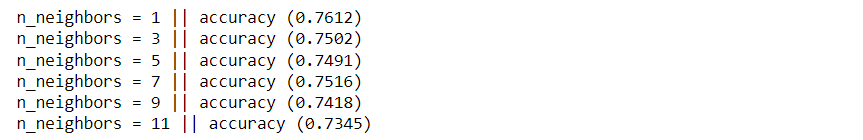
- there is no significant difference in the results, n_neighbors = 1 performs better but we will choose n_neighbors = 3 since it takes multirow assesment into account for better predictions, i think it is healthier

In [60]:
best_n= 3

### 4.3.a Handle Scaling & imputation
- After knn imputation, we need to perform some sort of scaling since our numeric columns have high skewness and not distributed normally> we scale the features to avoid meaningless weight affects 

#### (?) why RobustScaler 
- it uses iqr(interquartile range) to handle outliers, so its robust to outliers, since our dataset 
  has lots of outliers we better to use RobustScaler


In [61]:
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [62]:
X_knn = knn_pipeline.fit_transform(X)

### 4.4.a Handle Imbalance in the data 
- we've observed that our dataset is highly imbalanced
- The model may learn to predict the majority class most of the time and ignore the minority class, resulting in a high accuracy but low recall or precision
- The model may overfit to the majority class and generalize poorly to new or unseen data
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
- > Therefore we need to handle this imbalance situation

#### How to handle :
- Resampling: Over & undersampling
- SMOTE: Synthetic Minority Oversampling Technique
  > generate  synthetic samples for the minority class.
- TOMEK: remove the data that are identified as Tomek links from the majority class

- To add new data of minority class

    - Choose random data from the minority class.
    - Calculate the distance between the random data and its k nearest neighbors.
    - Multiply the difference with a random number between 0 and 1, then add the result to the  minority class as a synthetic sample.
    - Repeat step number 2–3 until the desired proportion of minority class is met.
- To remove the tomek links of the majority class
    - Choose random data from the majority class.
    - If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
  

In [63]:
from imblearn.combine import SMOTETomek # hybrid technique
# Resampling the minority class. 
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn,y)

### 4.5.a fit knn imputed data to models

In [64]:
report_knn = evaluate_models(X_res,y_res,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9949
- F1 score: 0.9949
- Precision: 0.9926
- Recall: 0.9971
- Roc Auc Score: 0.9949
- COST: 22090.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9844
- F1 score: 0.9845
- Precision: 0.9746
- Recall: 0.9946
- Roc Auc Score: 0.9843
- COST: 129950.
----------------------------------
Model performance for Test set
- Accuracy: 0.9789
- F1 score: 0.9791
- Precision: 0.9666
- Recall: 0.9920
- Roc Auc Score: 0.9789
- COST: 64040.


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9973
- F1 score: 0.9973
- Precision: 0.9958
- Recall: 0.9988
- Ro

In [65]:
report_knn

,Model Name,Cost
2,XGBClassifier,9620
3,CatBoosting Classifier,16910
0,Random Forest,22090
1,K-Neighbors Classifier,64040


#### Experiment #1 insights:
- For the Experiment 1: Knn imputer has XGBoost classifier as the best Model with a cost of 9620

### Experiment #2 Simple Imputer with Strategy Median

In [66]:
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [67]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [68]:
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
X_res, y_res = smt.fit_resample(X_median,y)

In [69]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9941
- F1 score: 0.9941
- Precision: 0.9906
- Recall: 0.9976
- Roc Auc Score: 0.9940
- COST: 19390.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9837
- F1 score: 0.9839
- Precision: 0.9737
- Recall: 0.9943
- Roc Auc Score: 0.9838
- COST: 137340.
----------------------------------
Model performance for Test set
- Accuracy: 0.9774
- F1 score: 0.9778
- Precision: 0.9651
- Recall: 0.9908
- Roc Auc Score: 0.9774
- COST: 72790.


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9968
- F1 score: 0.9968
- Precision: 0.9943
- Recall: 0.9993
- 

In [73]:
report_median

,Model Name,Cost
2,XGBClassifier,5840
3,CatBoosting Classifier,9990
0,Random Forest,19390
1,K-Neighbors Classifier,72790


#### Experiment #2 insights:
- For the Experiment 2: Simple median imputer has XGBoost classifier as the best Model with a cost of 5840

### Experiment #3 Mice Imputer

In [75]:
import miceforest as mf

In [76]:
X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [77]:
X_mice = kernel.complete_data()

In [78]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [79]:
# Fit X with Mice imputer 
X_mice= mice_pipeline.fit_transform(X_mice)

In [80]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [81]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9946
- F1 score: 0.9946
- Precision: 0.9914
- Recall: 0.9979
- Roc Auc Score: 0.9946
- COST: 16770.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9822
- F1 score: 0.9824
- Precision: 0.9718
- Recall: 0.9932
- Roc Auc Score: 0.9822
- COST: 162240.
----------------------------------
Model performance for Test set
- Accuracy: 0.9769
- F1 score: 0.9771
- Precision: 0.9658
- Recall: 0.9886
- Roc Auc Score: 0.9769
- COST: 88630.


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9972
- F1 score: 0.9972
- Precision: 0.9953
- Recall: 0.9991
- Ro

In [82]:
report_mice

,Model Name,Cost
2,XGBClassifier,7190
3,CatBoosting Classifier,14380
0,Random Forest,16770
1,K-Neighbors Classifier,88630


#### Experiment #3 insights:
- For the Experiment 3: Mice imputer has XGBoost classifier as the best Model with a cost of 7190

### Experiment #4  Simple Imputer with Strategy Constant

In [83]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [84]:
X_const =constant_pipeline.fit_transform(X)

In [85]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [86]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9935
- F1 score: 0.9935
- Precision: 0.9893
- Recall: 0.9978
- Roc Auc Score: 0.9935
- COST: 17600.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9839
- F1 score: 0.9841
- Precision: 0.9739
- Recall: 0.9944
- Roc Auc Score: 0.9839
- COST: 135240.
----------------------------------
Model performance for Test set
- Accuracy: 0.9775
- F1 score: 0.9779
- Precision: 0.9654
- Recall: 0.9907
- Roc Auc Score: 0.9775
- COST: 73740.


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9967
- F1 score: 0.9967
- Precision: 0.9938
- Recall: 0.9996
- Ro

In [87]:
report_const

,Model Name,Cost
2,XGBClassifier,3920
3,CatBoosting Classifier,9250
0,Random Forest,17600
1,K-Neighbors Classifier,73740


#### Experiment #4 insights:
- For the Experiment 4: Simple imputer with strategy constant has XGBoost classifier as the best Model with a cost of 3920

***

### Experiment #5 PCA with simple constant imputer

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables!

As the dataset has 160 columns we can try PCA and check our metrics Cost

In [89]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [90]:
X_pca = pca_pipeline.fit_transform(X)

In [91]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)


<Axes: >

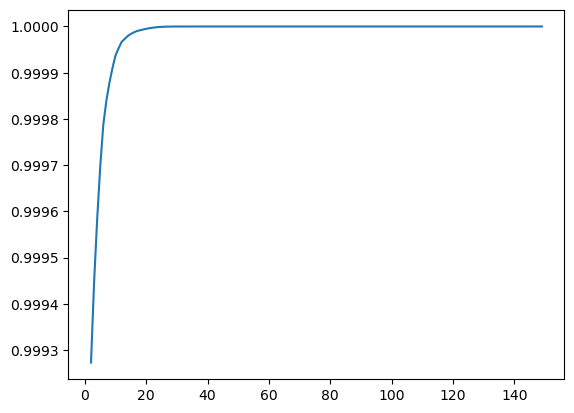

In [92]:
# plotting variance ratio
pd.Series(var_ratio).plot()

<Figure size 500x500 with 0 Axes>

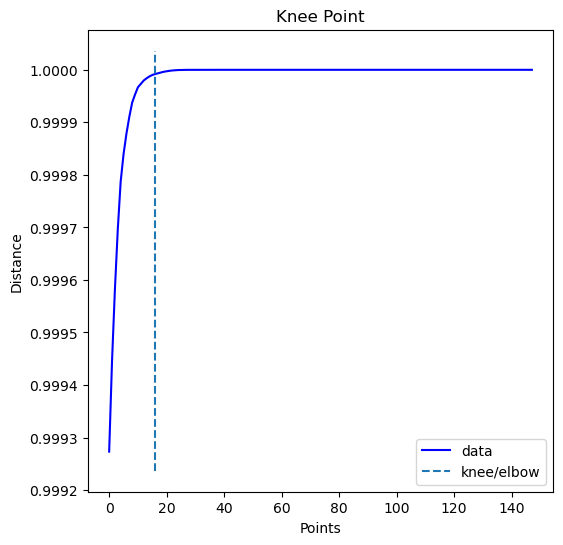

Knee Locator k = 18


In [95]:
#Kneed algorithm to find the elbow point
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [96]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [97]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [98]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9984
- F1 score: 0.9984
- Precision: 0.9999
- Recall: 0.9969
- Roc Auc Score: 0.9984
- COST: 68560.
----------------------------------
Model performance for Test set
- Accuracy: 0.9855
- F1 score: 0.9856
- Precision: 0.9814
- Recall: 0.9898
- Roc Auc Score: 0.9855
- COST: 77760.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9742
- F1 score: 0.9744
- Precision: 0.9678
- Recall: 0.9810
- Roc Auc Score: 0.9742
- COST: 432850.
----------------------------------
Model performance for Test set
- Accuracy: 0.9659
- F1 score: 0.9663
- Precision: 0.9574
- Recall: 0.9753
- Roc Auc Score: 0.9659
- COST: 187870.


XGBClassifier
Model performance for Training set
- Accuracy: 0.9886
- F1 score: 0.9886
- Precision: 0.9877
- Recall: 0.9896
- Roc Auc Score: 0.9886
- COST: 234940.
----------------------------------
Model performance for Test set
- Accuracy: 0.9788
- F1 score: 0.9790
- Precision: 0.9746
- Recall: 0

In [99]:
report_pca

,Model Name,Cost
0,Random Forest,77760
2,XGBClassifier,125770
3,CatBoosting Classifier,134600
1,K-Neighbors Classifier,187870


#### Experiment #5 insights:
- For the Experiment 5: PCA with Simple imputer with strategy constant has RandomForest as the best Model with a cost of 77760

# FINAL MODEL AND CONCLUSION

In [107]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","3920"])
pt.add_row(["XGBClassifier","Median","5840"])
pt.add_row(["XGBClassifier","Mice","7190"])
pt.add_row(["XGBClassifier","Knn-Imputer","9620"])
pt.add_row(["Random Forest","PCA","77760"])
print(pt)

+---------------+-------------------------+------------+
|     Model     |    Imputation_method    | Total_cost |
+---------------+-------------------------+------------+
| XGBClassifier | Simple Imputer-Constant |    3920    |
| XGBClassifier |          Median         |    5840    |
| XGBClassifier |           Mice          |    7190    |
| XGBClassifier |       Knn-Imputer       |    9620    |
| Random Forest |           PCA           |   77760    |
+---------------+-------------------------+------------+


## From the final report we can see than XGBClassifier with Simple imputer with strategy constant has performed the best with cost of 3920


In [1]:
final_model = XGBClassifier()

# Resampling the minority class.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

NameError: name 'XGBClassifier' is not defined

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.25,random_state=23)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [120]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 1.0
Final XGBoost Classifier Accuracy Score (Test) : 0.9966700645599729


In [121]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 3920


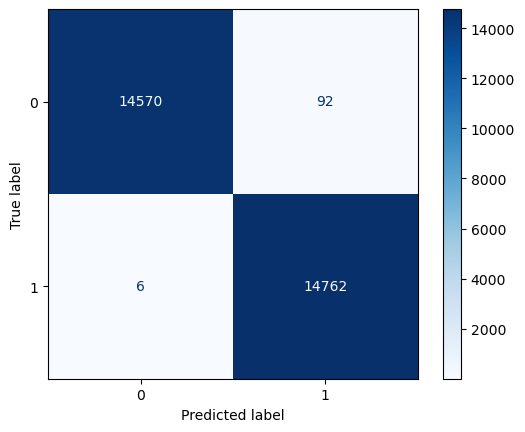

In [122]:
from sklearn.metrics import plot_confusion_matrix

#plots Confusion matrix
plot_confusion_matrix(final_model, X_test, y_test, cmap='Blues', values_format='d')

### The best Model is XGBoost Classifier due to the followings:
- high accuracy- low cost: 99.66% accuracy and cost of 3920
- computationally efficient imputation
- computationally efficient training